In [15]:
import netket as nk
import numpy as np
import matplotlib.pyplot as plt

<Axes: >

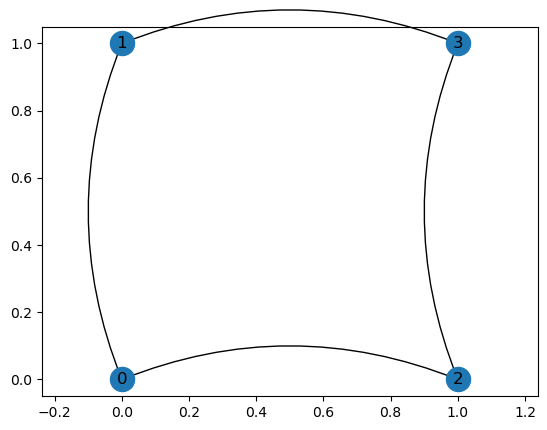

In [18]:
# playing with a simple 2x2 lattice

tiny_g_nk = nk.graph.Hypercube(length=2, n_dim=2, pbc=False)
tiny_g_nk.draw()

In [27]:
# spanning up the Hilbert space over 2 possible states per graph vertex
tiny_hi_nk = nk.hilbert.Spin(s=1/2, N=tiny_g_nk.n_nodes)

# defining the full Hamiltonian as field acting on one single site number 2
tiny_h_nk = nk.operator.spin.sigmax(tiny_hi_nk, 2)
tiny_h_nk = tiny_h_nk.to_dense()

In [20]:
# manually defining the same Hamiltonian using Kronecker products in numpy
sigma_0 = np.eye(2)
sigma_x = np.array([[0, 1], [1, 0]])

# the Hamiltonian is a tensor product of identity operators and a sigma_x at site 2
tiny_h_np = np.kron(np.kron(np.kron(sigma_0, sigma_0), sigma_x), sigma_0)

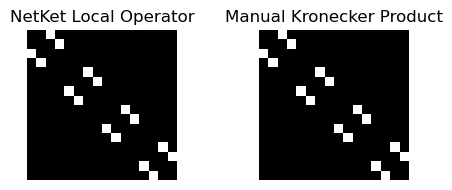

In [28]:
# comparing the two Hamiltonians

fig, axs = plt.subplots(1, 2, figsize=(5, 2))

axs[0].imshow(tiny_h_nk, cmap='gray', interpolation='nearest')
axs[0].set_title("NetKet Local Operator")
axs[1].imshow(tiny_h_np, cmap='gray', interpolation='nearest')
axs[1].set_title("Manual Kronecker Product")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

<Axes: >

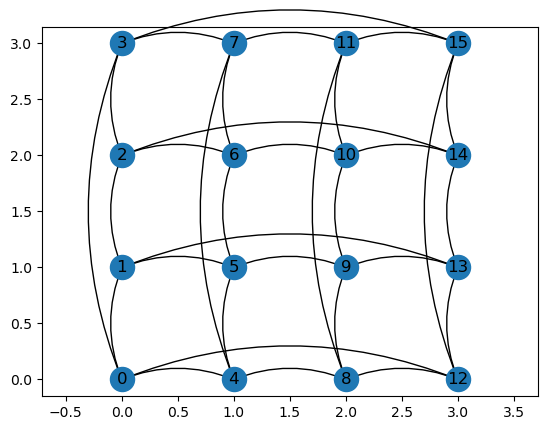

In [43]:
# manually defining the hamiltonian on a 4x4 spin lattice

# defining graph with edges connecting nearest neighbors and periodic boundary conditions
g = nk.graph.Hypercube(length=4, n_dim=2, pbc=True)
g.draw()

In [44]:
# spanning up the hilbert space over 2 possible states per graph vertex
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

# defining an empty hamiltonian and populating it with the local operators
h = nk.operator.LocalOperator(hi)

# sites are continuously enumerated, we add an external field term to each site
for site in g.nodes():
    # we create a big tensor product of identity operators and a sigma_z at the site we are interested in
    h -= nk.operator.spin.sigmax(hi, site)

# we add the interaction term between nearest neighbors
for edge in g.edges():
    # we multiply out the big tensor products between nearest neighbors
    h += nk.operator.spin.sigmaz(hi, edge[0]) @ nk.operator.spin.sigmaz(hi, edge[1])


# we perform a sanity check with the inbuilt Ising operator
hamiltonian_correct = nk.operator.Ising(hi, g, h=1.0, J=1.0)
assert np.sum(np.abs(hamiltonian_correct.to_sparse() - hamiltonian.to_sparse())**2) < 1e-5

In [45]:
# looping over the sites gives us 16 terms, looping over the edges gives us 32 terms resulting in 48 total pauli strings

h.to_pauli_strings()

PauliStrings(hilbert=Spin(s=1/2, N=16), n_strings=48, dtype=float64, dict(operators:weights)=
    XIIIIIIIIIIIIIII : -1.0,
    IXIIIIIIIIIIIIII : -1.0,
    IIXIIIIIIIIIIIII : -1.0,
    IIIXIIIIIIIIIIII : -1.0,
    IIIIXIIIIIIIIIII : -1.0,
    IIIIIXIIIIIIIIII : -1.0,
    IIIIIIXIIIIIIIII : -1.0,
    IIIIIIIXIIIIIIII : -1.0,
    IIIIIIIIXIIIIIII : -1.0,
    IIIIIIIIIXIIIIII : -1.0,
    IIIIIIIIIIXIIIII : -1.0,
    IIIIIIIIIIIXIIII : -1.0,
    IIIIIIIIIIIIXIII : -1.0,
    IIIIIIIIIIIIIXII : -1.0,
    IIIIIIIIIIIIIIXI : -1.0,
    IIIIIIIIIIIIIIIX : -1.0,
    IIIZIIIZIIIIIIII : 1.0,
    IIIIIIIIIIIIZZII : 1.0,
    IIIIIIIIZZIIIIII : 1.0,
    IIIIIIIIZIIIZIII : 1.0,
    IIZIIIIIIIIIIIZI : 1.0,
    IIIIIIIIIIIIIZZI : 1.0,
    IIIIZZIIIIIIIIII : 1.0,
    IIIIIZZIIIIIIIII : 1.0,
    IIIIZIIIZIIIIIII : 1.0,
    IIIIIIIIIIIIZIIZ : 1.0,
    IIIIIZIIIZIIIIII : 1.0,
    IIIIIIIIIIIIIIZZ : 1.0,
    IIIZIIIIIIIIIIIZ : 1.0,
    IIIIIIIIZIIZIIII : 1.0,
    ZZIIIIIIIIIIIIII : 1.0,
    IIIIIIIIIZZIIIII :

In [55]:
# we see that the hamiltonian is extremely sparse, with only 48 non-zero elements out of the full hamiltonian.

# print shape of the dense hamiltonian
h.to_dense().shape

(65536, 65536)

In [59]:
# compare memory footprint of the dense and sparse hamiltonian
mem_sparse_h = h.to_sparse().data.nbytes + h.to_sparse().indices.nbytes + h.to_sparse().indptr.nbytes
mem_dense_h = h.to_dense().nbytes

print(f"Memory footprint of sparse hamiltonian: {mem_sparse_h / 1e6:.2f} MB")
print(f"Memory footprint of dense hamiltonian: {mem_dense_h / 1e6:.2f} MB")

Memory footprint of sparse hamiltonian: 13.63 MB
Memory footprint of dense hamiltonian: 34359.74 MB


The sparse representation of a Hamiltonian is actually a `csr_matrix` from the `scipy.sparse` module. It stores nonzero elements in a `data` array. The locations are indexed in a hierarchical way using two auxiliary arrays: `indices` and `indptr`.

**Example:**

For the matrix:

$$
\begin{bmatrix}
0 & 4 & 0 \\
0 & 0 & 0 \\
3 & 0 & 5
\end{bmatrix}
$$

The CSR representation is:

- **`data`** = [4, 3, 5]  *(nonzero elements)*
- **`indices`** = [1, 0, 2]  *(column indices of each element within its row)*
- **`indptr`** = [0, 1, 1, 3]  *(row boundaries)*

Here, `indptr` tells us which row is skipped. We have a sliding window of 2 which slices up the `indices` array according to rows.
Row 1 is empty because `indptr[1] == indptr[2]`.